In [1]:
import numpy as np
import pandas as pd
from astropy.table import Table, vstack
from matplotlib import pyplot as plt
from glob import glob
from astropy.stats import LombScargle
from astroquery.simbad import Simbad
import astropy.coordinates as coord
import astropy.units as u
from scipy import stats
import warnings
from TESStools import *

%matplotlib inline

In [2]:
short_cadence_xmatch = '../data/tess_gaia_magnitudes.csv'

data = pd.read_csv(short_cadence_xmatch)

In [9]:
sec12 = data#[(~np.isnan(data['tess_sector1_oid']))|(~np.isnan(data['tess_sector2_oid']))]

In [10]:
len(sec12)

119700

In [11]:
#accounting for nonexistant A_G
nanmags = data[np.isnan(data['M_G'])]
nanmags['M_G_low'] = nanmags['phot_g_mean_mag'] - 5.0*np.log10(nanmags['r_est']) + 5
nanmags['BR_hi'] = nanmags['phot_bp_mean_mag']-nanmags['phot_rp_mean_mag']

/Users/carina/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()
/Users/carina/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


(-90, 90)

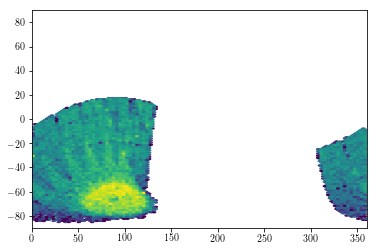

In [12]:
plt.hexbin(data['ra'],data['dec'],mincnt=1,bins='log')
plt.xlim(0,360)
plt.ylim(-90,90)

In [13]:
#2018A&A...616A..12G (Helmi et al. 2018) did the filtering for stars in the MCs
lmc_ids = Table.read('../data/lmc_gaiaids.fits',format='fits').to_pandas()
smc_ids = Table.read('../data/smc_gaiaids.fits',format='fits').to_pandas()

In [14]:
lmc_data = pd.merge(data,lmc_ids,left_on='source_id',right_on='Source')
smc_data = pd.merge(data,smc_ids,left_on='source_id',right_on='Source')
mcs = pd.concat([lmc_data,smc_data])
galactic_data = data[~data['source_id'].isin(mcs['source_id'])]

#Coefficients from Malhan, Ibata & Martin (2018a), ratio of A_X/A_V
ag_av = 0.85926
ab_av = 1.06794
ar_av = 0.65199

lmc_RV = 3.41 #Gordon et al. 2003
lmc_EBV = 0.13 #Massey et al. 2007
lmc_EBPRP = (lmc_RV*lmc_EBV)*(ab_av-ar_av)
lmc_AG = (lmc_RV*lmc_EBV)*ag_av
lmc_data['(BP_RP)_0'] = lmc_data['phot_bp_mean_mag'] - lmc_data['phot_rp_mean_mag'] - lmc_EBPRP
#distance modulus from Kovacs 2000b
lmc_data['M_G'] = lmc_data['phot_g_mean_mag'] - 18.52 - lmc_AG #kovacs 2000

smc_RV = 2.75 #Gordon et al. 2003
smc_EBV = 0.09 #Massey et al. 2007
smc_EBPRP = (smc_RV*smc_EBV)*(ab_av-ar_av)
smc_AG = (smc_RV*smc_EBV)*ag_av
smc_data['(BP_RP)_0'] = smc_data['phot_bp_mean_mag'] - smc_data['phot_rp_mean_mag'] - smc_EBPRP
#distance modulus from Kovacs 2000a
smc_data['M_G'] = smc_data['phot_g_mean_mag'] - 19.05 - smc_AG #kovacs 2000

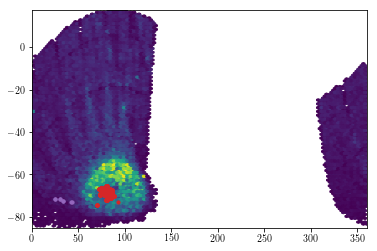

In [15]:
plt.hexbin(galactic_data['ra'],galactic_data['dec'],mincnt=1)
plt.scatter(lmc_data['ra'],lmc_data['dec'],s=10,c='C3')
plt.scatter(smc_data['ra'],smc_data['dec'],s=10,c='C4')

In [16]:
#Now let's try to isolate massive stars using MIST. Take all isochrones with initial mass > 8
Mnames = ('EEP', 'log10_isochrone_age_yr', 'initial_mass', 'star_mass', 'log_Teff', 
          'log_g', 'log_L', '[Fe/H]_init', '[Fe/H]', 'Bessell_U', 'Bessell_B', 'Bessell_V', 
          'Bessell_R', 'Bessell_I', '2MASS_J', '2MASS_H', '2MASS_Ks', 'Kepler_Kp', 'Kepler_D51', 
          'Hipparcos_Hp', 'Tycho_B', 'Tycho_V', 'Gaia_G_DR2Rev', 'Gaia_BP_DR2Rev', 
          'Gaia_RP_DR2Rev', 'TESS', 'phase')

MWnames = ('EEP','log10_isochrone_age_yr','initial_mass','star_mass','log_Teff',
           'log_g','log_L','[Fe/H]_init','[Fe/H]','WISE_W1','WISE_W2','WISE_W3',
           'WISE_W4','phase')

#Adopting [Fe/H] = +0.25,-0.5,-1 for galactic massive stars, the LMC, and the SMC respectively...
Galfile = '../../GaiaSprintMassive/WISE/data/MIST/MIST_v1.1_vvcrit0.4_UBVRIplus/MIST_v1.1_feh_p0.25_afe_p0.0_vvcrit0.4_UBVRIplus.iso.cmd'
LMCfile = '../../GaiaSprintMassive/WISE/data/MIST/MIST_v1.1_vvcrit0.4_UBVRIplus/MIST_v1.1_feh_m0.50_afe_p0.0_vvcrit0.4_UBVRIplus.iso.cmd'
SMCfile = '../../GaiaSprintMassive/WISE/data/MIST/MIST_v1.1_vvcrit0.4_UBVRIplus/MIST_v1.1_feh_m1.00_afe_p0.0_vvcrit0.4_UBVRIplus.iso.cmd'

Gmist = pd.read_table(Galfile, delim_whitespace=True, comment='#', names=Mnames)
Lmist = pd.read_table(LMCfile, delim_whitespace=True, comment='#', names=Mnames)
Smist = pd.read_table(SMCfile, delim_whitespace=True, comment='#', names=Mnames)

min_col_arrs = ()
min_mag_arrs = ()

for mist in [Gmist,Lmist,Smist]:
    
    mist_massive = mist[(mist['initial_mass'] >= 8)]

    #Now, in each color bin, give me the color and magnitude of the faintest star.
    col_bins = np.linspace(-0.25,3,100)
    min_cols = []
    min_mags = []

    for i,left in enumerate(col_bins[:-1]):
        mist_subset = mist_massive[(mist_massive['Gaia_BP_DR2Rev']-mist_massive['Gaia_RP_DR2Rev']>left)&
                                   (mist_massive['Gaia_BP_DR2Rev']-mist_massive['Gaia_RP_DR2Rev']<=col_bins[i+1])]
        min_point = mist_subset[mist_subset['Gaia_G_DR2Rev']==np.max(mist_subset['Gaia_G_DR2Rev'])]
        if len(min_point) != 0:
            min_cols.append((min_point['Gaia_BP_DR2Rev'].values-min_point['Gaia_RP_DR2Rev'].values)[0])
            min_mags.append((min_point['Gaia_G_DR2Rev'].values)[0])
    min_col_arrs += (min_cols, )
    min_mag_arrs += (min_mags, )
    
Gmin_cols, Lmin_cols, Smin_cols = min_col_arrs
Gmin_mags, Lmin_mags, Smin_mags = min_mag_arrs

/Users/carina/anaconda/lib/python3.5/site-packages/IPython/core/interactiveshell.py:2785: DtypeWarning: Columns (8) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


Text(0, 0.5, '$M_G$')

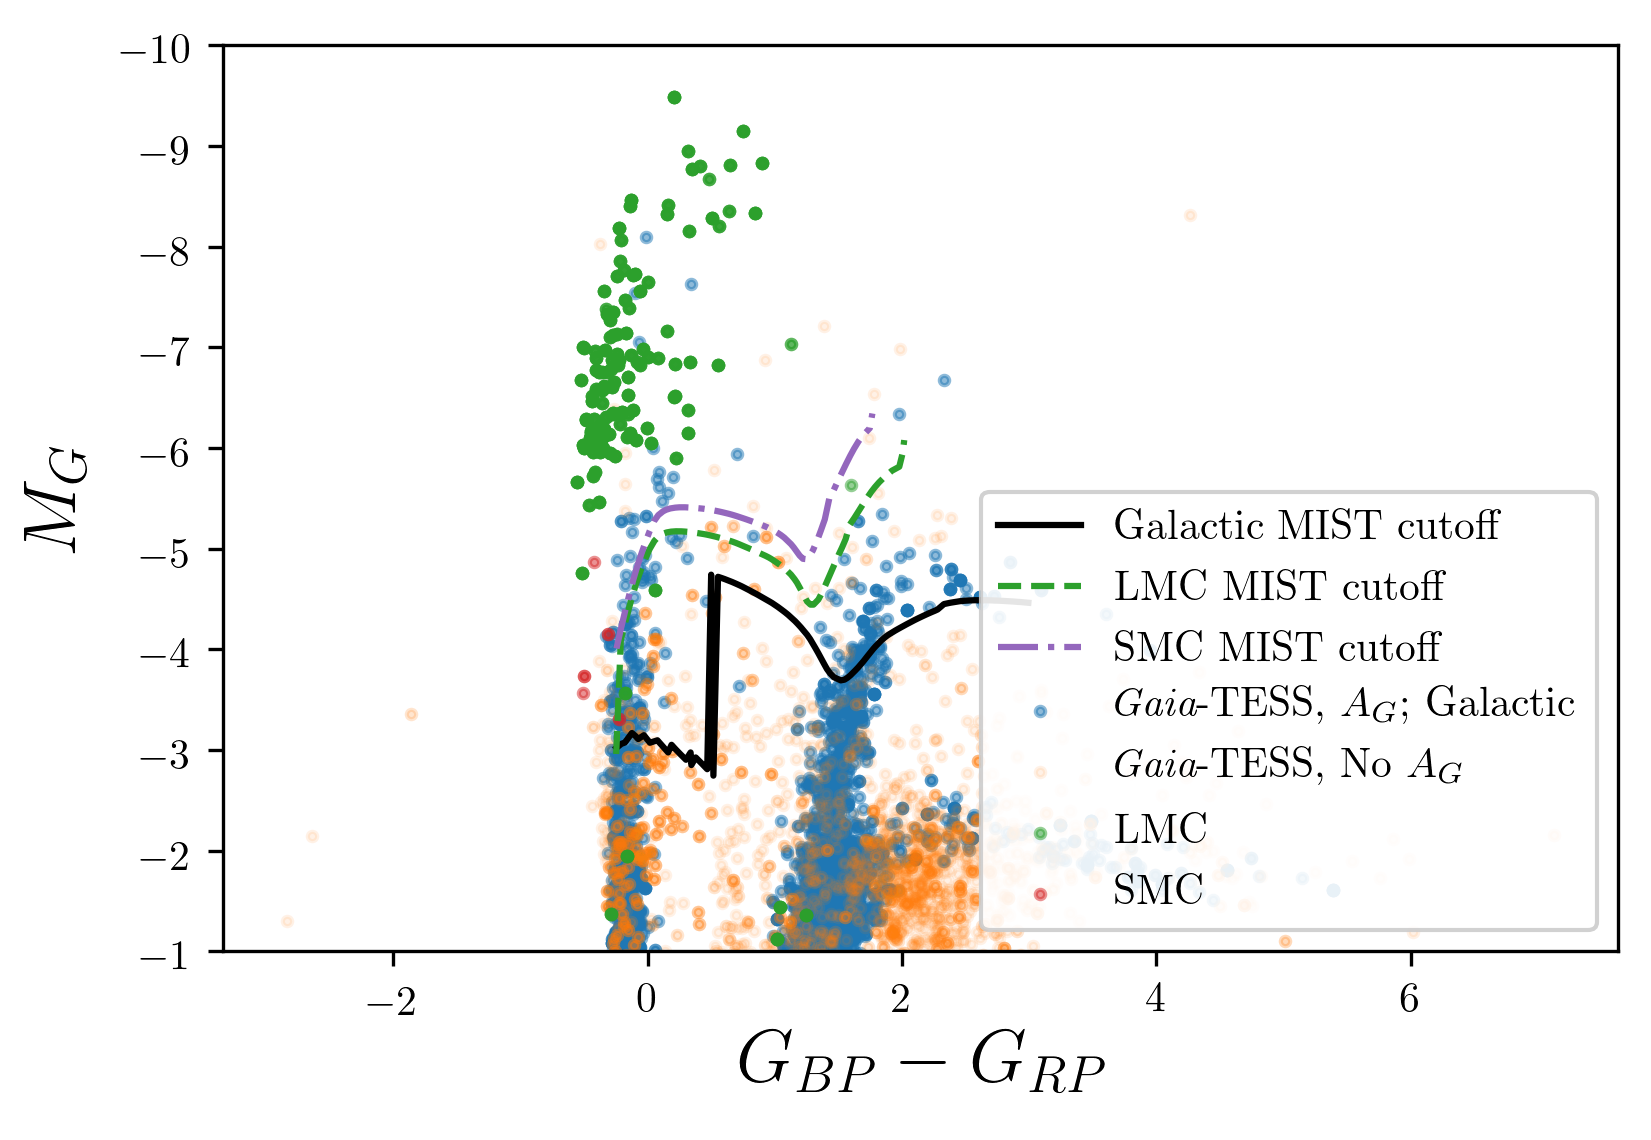

In [17]:
fig = plt.figure(dpi=300)
plt.scatter(galactic_data['(BP_RP)_0'],galactic_data['M_G'],s=5,alpha=0.5,label='{\it Gaia}-TESS, $A_G$; Galactic')
plt.scatter(nanmags['BR_hi'].values,nanmags['M_G_low'].values,s=5,alpha=0.1,label='{\it Gaia}-TESS, No $A_G$')
plt.scatter(lmc_data['(BP_RP)_0'],lmc_data['M_G'],s=5,alpha=0.5,label='LMC')
plt.scatter(smc_data['(BP_RP)_0'],smc_data['M_G'],s=5,alpha=0.5,label='SMC')
plt.plot(Gmin_cols,Gmin_mags,'-k',label='Galactic MIST cutoff')
plt.plot(Lmin_cols,Lmin_mags,'--C2',label='LMC MIST cutoff')
plt.plot(Smin_cols,Smin_mags,'-.C4',label='SMC MIST cutoff')
#keep track of if we've done the label or not
red_flag = False
black_flag = False

"""for tid in np.unique(massive['ticid']):
    
    if (tid in paper_tids) or (tid in lmc_xmatch['ticid'].values):
        pass
    else:
        c = 'k'
        alpha = 0.3
        if not black_flag:
            label = 'Not Included'
            black_flag = True
        else:
            label = None

        row = massive.loc[massive['ticid'] == tid].iloc[0]
        if np.isnan(row['M_G_low']):
            plt.scatter(row['(BP_RP)_0'],row['M_G'],lw=1,marker='s',c='k',alpha=0.3,label=label)
        else:
            plt.scatter(row['BR_hi'],row['M_G_low'],lw=1,marker='s',c='k',alpha=0.3,label=label)
            
for tid in paper_tids:
    
    c = 'k'
    alpha = 0.3
    if not red_flag:
        label = 'This Study'
        red_flag = True
    else:
        label = None

    row = massive.loc[massive['ticid'] == tid].iloc[0]
    if np.isnan(row['M_G_low']):
        plt.scatter(row['(BP_RP)_0'],row['M_G'],lw=1,marker='s',c='none',edgecolors='r',alpha=1,label=label)
    else:
        plt.scatter(row['BR_hi'],row['M_G_low'],lw=1,marker='s',c='none',edgecolors='r',alpha=1,label=label)
"""    
plt.ylim(-1,-10)
plt.legend(loc=4,framealpha=0.9)
plt.xlabel('$G_{BP} - G_{RP}$',fontsize=18)
plt.ylabel('$M_G$',fontsize=18)
#plt.savefig('../plots/CMD.pdf')

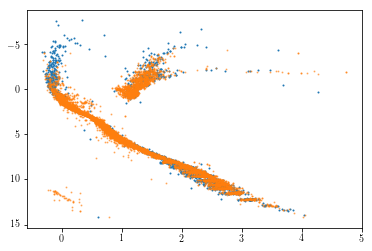

In [56]:
disk = galactic_data[np.abs(galactic_data['b'])<5]
halo = galactic_data[np.abs(galactic_data['b'])>50]
plt.scatter(disk['(BP_RP)_0'],disk['M_G'],s=1)
plt.scatter(halo['(BP_RP)_0'],halo['M_G'],alpha=0.5,s=1)
plt.gca().invert_yaxis()

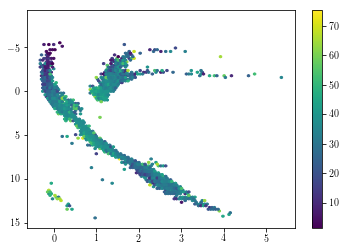

In [65]:
plt.hexbin(galactic_data['(BP_RP)_0'],galactic_data['M_G'],C=np.abs(galactic_data['b']),mincnt=1)
plt.colorbar()
plt.gca().invert_yaxis()